In [3]:
%%HTML
<!-- Mejorar visualización en proyector -->
<style>
.rendered_html {font-size: 1.2em; line-height: 150%;}
div.prompt {min-width: 0ex; padding: 0px;}
.container {width:95% !important;}
</style>

In [2]:
%matplotlib notebook
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

### Ejemplo de inferencia paramétrica

- Queremos estimar los parámetros $\mu$ y $\sigma^2$ de la población
- A partir de las observaciones construimos una estadístico muestral: $\bar X = \sum_i X_i/N$
- Si **asumimos** que la población se distribuye normal entonces: $\bar X = \mathcal{N}(\mu, \sigma^2/N)$, es decir que 
    - En promedio la media muestral equivale a la media de la población
    - A mayor número de muestras menor es la varianza de nuestro estimador
- Para tomar decisiones basados en $\bar X$ usamos un estadístico de test: $t = \frac{\bar X - \mu}{\sqrt{\hat \sigma^2/N}}$ (o estadístico Z si $\sigma$ es conocido)
- Dado que conocemos la distribución de $\bar X$ podemos calcular la distribución de $t$ bajo la hipótesis nula (e.g. $\mu=0$) y calcular el p-value 

> p-value: pbb de observar un valor más grande que t si la hipótesis nula fuera cierta

### El análisis descansa en los supuestos sobre la distribución de la población

¿Qué ocurre en el ejemplo anterior si el supuesto sobre la distribución población estaba equivocado?

La distribución muestral será erronea, la distribución nula será erronea y el p-value será erroneo

### Horror ¿Qué hago?

1. (Mantén la calma)
1. En la práctica los tests parámetricos funcionan con "ligeras" desviaciones de los supuestos
1. Podemos comprobar los supuestos antes de hacer el análisis
1. Si los supuestos no se cumplen podemos usar **inferencia no paramétrica**

# Evaluando normalidad

La normalidad es un supuesto usado en muchos procedimientos parámetricos: t-test, ANOVA, regresion lineal

Tengamos en cuanta las características principales de la distribución normal
- Unimodal con media igual a su moda
- Simétrica en torno a la media
- Concentrada en torno a la media: ~68% a $\pm \sigma$, ~95% a $\pm 2\sigma$, ...

Si tenemos suficientes muestras podriamos observar el histograma y comprobar visualmente si esto se cumple

In [9]:
scipy.stats.norm(loc=2, scale=1).cdf(3) - scipy.stats.norm(loc=2, scale=1).cdf(2)

0.3413447460685429

<IPython.core.display.Javascript object>


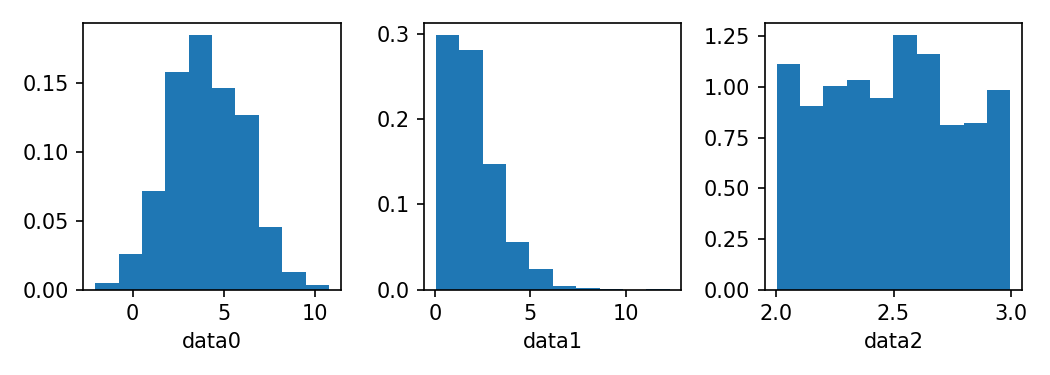

In [4]:
data1 = scipy.stats.norm(loc=4, scale=2).rvs(1000)
data2 = scipy.stats.gamma(a=2, scale=1).rvs(1000)
data3 = scipy.stats.uniform(loc=2, scale=1).rvs(1000)

fig, ax = plt.subplots(1, 3, figsize=(7, 2.5), tight_layout=True)
for i, data in enumerate([data1, data2, data3]):
    #data = (data - np.mean(data))/np.std(data)
    ax[i].hist(data, bins=10, density=True)
    ax[i].set_xlabel('data'+str(i))

### Momentos estadísticos

En el caso particular de la normal sabemos que el tercer momento (simetría) debiese ser cero

Podemos calcular la simetría usando [`scipy.stats.skew`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html), para el caso particular de la normal puede ser util [`scipy.stats.skewtest`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skewtest.html)

In [5]:
for i, data in enumerate([data1, data2, data3]):
    display(scipy.stats.skew(data))

0.0581982421945608

1.4998886184310916

0.03457860826500735

El cuarto momento (kurtosis) también tiene un valor particular en el caso de la distribución normal

La función [`scipy.stats.kurtosis`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosis.html) tiene dos definiciones de Kurtosis

La definición por defecto (Fisher) nos da cero en el caso de que la distribución sea normal

Puede ser también util [`scipy.stats.kurtosistest`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosistest.html)

In [6]:
for i, data in enumerate([data1, data2, data3]):
    display(scipy.stats.kurtosis(data))

-0.24264931523278488

4.411666053439928

-1.1038766262648614

### Probability plots

Otra opción gráfica son los *probability plots* (Chambers et al., 1983) 

Se calculan los cuantiles (qq) o percentiles (pp) de dos muestras o de una muestra y una distribución teórica

Luego se grafican. Mientras más se parezca el resultado a una linea recta más similares son las distribuciones

Para mayores detalles teóricos: https://itl.nist.gov/div898/handbook/eda/section3/probplot.htm

Podemos usar `scipy.stats.probplot` para comparar una muestra con una distribución teórica 

- En este caso la distribución teórica será la normal estándar
- Dado que la prueba es basada en rangos no necesitamos entregar parámetros de localización (media) o escala (varianza)
- Cualquier parámetro de otro tipo (shape) se debe indicar




<IPython.core.display.Javascript object>


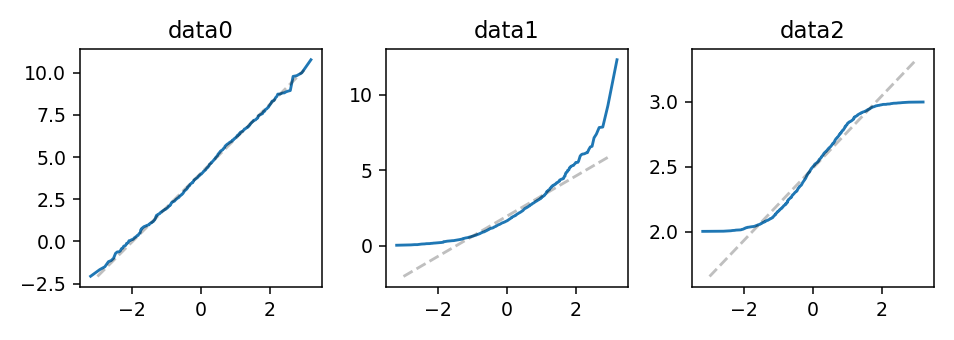

0.9990794976993385
0.9474951274436407
0.9814394841117512


In [16]:
fig, ax = plt.subplots(1, 3, figsize=(7, 2.5), tight_layout=True)
for i, data in enumerate([data1, data2, data3]):
    #data = ((data - np.mean(data))/np.std(data)).copy()
    (osm, osr), (w, b, r2) = scipy.stats.probplot(data, dist="norm", fit=True);
    ax[i].plot(osm, osr)
    #print(r2)
    ax[i].plot(np.arange(-3, 4), np.arange(-3, 4)*w + b, 'k--', alpha=0.25)
    ax[i].set_title('data'+str(i));

### Nuestro primer test no-paramétrico:  Kolmogorov-Smirnov (KS)

Este test examina la distancia entre las funciones de distribución acumulada (CDF) de dos muestras

- Solo se puede usar para distribuciones univariadas continuas
- Si se compara una muestra empírica con una CDF teórica: Test de KS de una muestra
- Si se comparan dos muestras empíricas: Test de KS de dos muestras

> Test no-paramétrico: No asume distribuciones

El estadístico de test es para KS de una muestra es

$$
D_n = \sup_x |F_n(x) - F(x)|
$$

donde $F(x) = \int_{-\infty}^x f(x) dx = P(X<x)$ es la CDF teórica y 

$$
F_n(x) = \frac{1}{N} \sum_{i=1}^N \mathbb{1}[X_i<x]
$$

es la distribución acumulada empírica (ECDF)

<IPython.core.display.Javascript object>


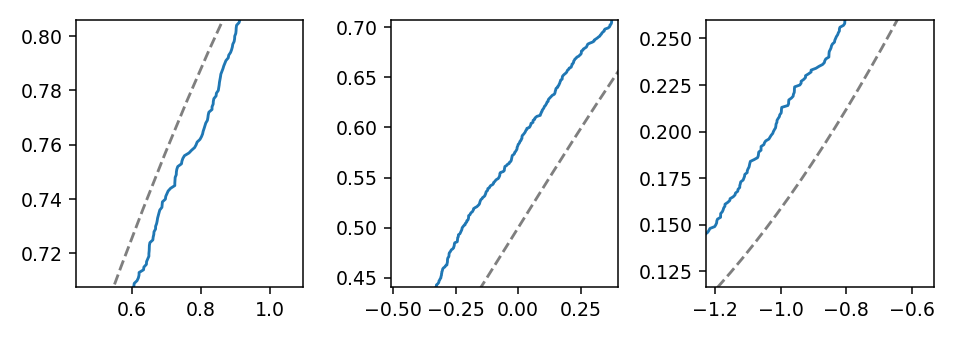

In [19]:
def ecdf(data):
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return(x,y)

fig, ax = plt.subplots(1, 3, figsize=(7, 2.5), tight_layout=True)
for i, data in enumerate([data1, data2, data3]):
    # ECDF
    data = ((data - np.mean(data))/np.std(data)).copy()
    x, y = ecdf(data)
    ax[i].plot(x, y)
    # CDF standard normal
    x_t = np.linspace(np.amin(data), np.amax(data), num=100)
    y_t = scipy.stats.norm.cdf(x_t)    
    ax[i].plot(x_t, y_t, 'k--', alpha=0.5)

> $D_n$ es la distancia más larga entre todas las distancias de la CDF teórica y empírica

Las hipótesis de la prueba KS de una muestra son

- $\mathcal{H}_0$: Los datos siguen la distribución teórica especificada
- $\mathcal{H}_A$: Los datos no siguen la distribución teórica especificada

Si $D_n$ es menor que el valor crítico no podemos rechazar $H_0$

Podemos usar `scipy.stats.kstest` para probar nuestros datos contra la distribución normal

In [22]:
for i, data in enumerate([data1, data2, data3]):
    data = ((data - np.mean(data))/np.std(data)).copy()
    Dn, pvalue = scipy.stats.kstest(data, scipy.stats.norm.cdf) #Acepta una cdf o un string, e.g. 'norm'
    print(i, Dn, pvalue)
    if pvalue < 0.05:
        display("Rechazo la hipótesis nula: nuestros datos no siguen la distribución especificada")

0 0.026552038375862175 0.4797525029999229
1 0.09067939394043012 1.321308344276559e-07


'Rechazo la hipótesis nula: nuestros datos no siguen la distribución especificada'

2 0.055333933599135354 0.004210085183647687


'Rechazo la hipótesis nula: nuestros datos no siguen la distribución especificada'

Problemas de Kolmogorov-Smirnov

- Solo para distribuciones continuas y univariadas
- Es más sensible en el centro que en las colas de la distribución
- Se debe especificar completamente la distribución teórica

#### Opciones

Si mi distribución es discreta: Test de chi cuadrado

Mejora de KS que le da más ponderación a las colas
- [Test de Anderson-Darling](https://www.itl.nist.gov/div898/handbook/prc/section2/prc213.htm), con implementación en [`scipy.stats.anderson`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html)  (normal, exponencial y gumbel)
- [Test de Shapiro-Wilks](https://www.itl.nist.gov/div898/handbook/prc/section2/prc213.htm) test con implementación en [`scipy.stats.shapiro`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html) (solo normal)

Si se quiere probar normalidad pero no se sabe la media o la varianza se puede usar el test de [Lilliefors](https://www.statsmodels.org/0.6.1/generated/statsmodels.stats.diagnostic.lillifors.html?highlight=lilliefors)


### Ejemplo, test de Anderson Darling con scipy:

In [23]:
for i, data in enumerate([data1, data2, data3]):
    #data = ((data - np.mean(data))/np.std(data)).copy() # no requiere estandarización
    statistic, critical_value, significance_level = scipy.stats.anderson(data, 'norm')
    print(i, statistic)
    if statistic > critical_value[significance_level==5.][0]:
        display("Rechazo la hipótesis nula: nuestros datos no siguen la distribución especificada")

0 0.7490163452747538
1 19.599491087423417


'Rechazo la hipótesis nula: nuestros datos no siguen la distribución especificada'

2 8.305783034826163


'Rechazo la hipótesis nula: nuestros datos no siguen la distribución especificada'

# Actividad 

Use las herramientas que acabamos de estudiar para probar la normalidad de los siguientes datos

In [25]:
scipy.stats.lognorm?

In [49]:
data = np.loadtxt('mistery_data.txt')
Dn, pvalue = scipy.stats.kstest(np.log(data), scipy.stats.norm().cdf)
display(Dn)
Dn, pvalue = scipy.stats.kstest((data), scipy.stats.lognorm(s=1).cdf)
display(Dn)

0.9997800191940905

0.9997800191940905

Transforme los datos usando logaritmo y repita el procedimiento

¿A que distribución corresponde?

# Inferencia no paramétrica

Inferencia: Estimar parámetros o probar hipótesis sobre una población

En inferencia **no parámetrica** usamos estadísticos cuya distribución **no depende de supuestos sobre la distribución de la población**

- No paramétrico $=$ No asumimos **distribución específica** para la población 
- No paramétrico $\neq$ Libre de supuestos (e.g. continuidad, muestras independientes)
- No paramétrico $\neq$ Sin parámetros (e.g. la cantidad de bines de un histograma)

Trade-off: 

- Si sus supuestos se cumplen, los métodos parámetricos son la ópcion de mayor poder estadístico (sensibilidad)
- Los métodos no-parámetricos tienen un poder igual o menor pero no requieren de supuestos

En clases anteriores vimos
- Histograma
- Kernel Density Estimation
- Bootstrap

En esta clase complementaremos con otras herramientas y tests no paramétricos

### Función cuantil y estadístico de orden


La CDF se define como
$$
P(X<x) = F(x) = p,
$$
donde $p\in [0, 1]$

En algunos casos nos interesa saber que valor $x$ corresponde a un valor dado $p$

Esto se hace con la función cuantil o CDF inversa

$$
Q(p) = \inf_{x\in \mathbb{R}} p \leq F(x)
$$

En scipy podemos calcular $x$ a partir de $p$ usando el atributo `ppf` (percent-point function) de una distribución 

In [50]:
# Que valor de x corresponde a un 50% de la distribución?
display(scipy.stats.norm.ppf(0.5))
# y a un 99%?
display(scipy.stats.norm.ppf(0.99))

0.0

2.3263478740408408

Sea ${X_1, X_2, X_3, \ldots, X_N}$ un conjunto de VAs iid y ${x_1, x_2, x_3, \ldots, x_N}$ una muestra aleatoria

Si asumimos que la población tiene una CDF continua (no hay dos VA con el mismo valor) entonces podemos hacer un ordenamiento único

$$
x_{(1)} < x_{(2)} < x_{(3)} < \ldots < x_{(N)} 
$$

que se llaman colectivamente el estadístico de orden de la muestra aleatoria y $x_{(r)}$ se llama el estadístico de orden r

Con este ordenamiento podemos construir la ECDF

$$
F_N(x) = \begin{cases} 0 & x < x_{(1)} \\ 
\frac{i}{N} & x_{(i-1)} \leq x < x_{(i)},  i=2,3,\ldots,N \\ 
1 & x_{(N)} < x\end{cases}
$$


In [51]:
def ecdf(data):
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return(x,y)

#### Propiedades de la ECDF

$$
\mathbb{E}[F_N(x)] = F(x)
$$

y 

$$
\text{Var}[F_N(x)] = \frac{1}{N} F(x) ( 1- F(x))
$$

> La ECDF es un estimador insesgado de la CDF y su varianza tiene a cero con $N$

Adicionalmente la ECDF
- es un estimador consistente de $F(x)$ (converge en probabilidad) 
- (estandarizada) es un asintoticamente normal estándar


#### Función cuantil empírica

También podemos usar el estadístico de orden para construir la función cuantil empírica

$$
Q_N(u) = \begin{cases}
x_{(1)} &  0 < u \leq \frac{1}{N} \\
x_{(2)} & \frac{1}{N} < u  \leq\frac{2}{N} \\
\vdots & \vdots \\
x_{(N)} & \frac{(N-1)}{N} < u  \leq 1 \\
\end{cases}
$$

In [52]:
data = np.random.randn(1000)
display(np.quantile(data, 0.5)) # NUMEROS ENTRE 0 Y 1
display(np.percentile(data, 50)) # NUMEROS ENTRE 0 Y 100

0.03658503436633713

0.03658503436633713

#### Aplicaciones de estadísticos de orden

- El rango es $x_{N} - x_{1}$
- La mediana es un $x_{(n/2)}$ (n par)

Los estadísticos de orden suelen ser más robustos que sus contrapartes en la presencia de *outliers*

Podemos calcular la mediana con `np.median`

In [53]:
x = np.random.randn(10) # media cero
x[9] = 100
display(np.mean(x))
display(np.median(x))

10.411160036508743

0.5556716362359918

Y el rango intercuartilico (diferencia entre cuantil 0.75 y 0.25) con `np.percentile`

In [54]:
display(np.std(x))
display(np.subtract.reduce(np.quantile(x, [0.75, 0.25])))

29.878389913510773

1.9263584644483118

# Tests no paramétricos

El test de KS que vimos antes es un ejemplo de test no paramétrico

Las propiedades de la ECDF nos permiten construir distribuciones nulas sin necesidad de asumir una distribución para la población

Existen muchos otros tests no-paramétricos, a continuación revisaremos algunos

## Test de Mann-Whitney U

Es una prueba no-paramétrica para comparar dos **muestras independientes**

> Muestras independientes: notas de niños y niñas en una prueba

> Muestras dependientes: notas de un mismo curso en dos pruebas

El objetivo es probar si provienen de una misma población (en función de su tendencia central)

Una forma parámetrica de probar esto es el t-test para comparar dos medias $\mu_0$ y $\mu_1$. Pero este test asume normalidad

El test de Mann-Whitney U en cambio no supone distribución para la población y algunos lo interpretan como una comparación entre medianas

La hipótesis nula es que no hay diferencia entre las distribuciones muestrales

> La prueba mezcla y ordena las observaciones de ambas muestras. Intutivamente, si las muestras son similares entonces sus observaciones deberían mezclarse en el ordenamiento. Si en cambio se clusterizan entonces las distribuciones son distintas

#### Algoritmo

1. Ordenar las observaciones de ambas muestras juntas
1. Sumar los rangos de la primera muestra $R_1$. $R_2$ queda definida ya que $R_1 + R_2 = \frac{N(N+1)}{2}$
1. Se calcula el estadístico $U_1 = R_1 - \frac{N_1(N_1+1)}{2}$, donde $N_1$ es el número de observaciones de la primera muestra. Por simetría $U_2$ queda inmediatamente especificado
1. Se usa $\min(U_1, U_2)$ para calcular el p-value

Esta prueba requiere al menos 20 observaciones en cada muestra para que sea efectiva

La prueba está implementada en [`scipy.stats.mannwhitneyu`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html)

## Actividad

Se tiene una base de datos de gasto energético en [kJ] y un indicador que clasifica a la persona como Obeso (0) o Delgado (1)

Use el test de Mann Whitney U para comparar las distribuciones

In [68]:
energy = np.load('gasto_energético.npy')
# Primera columna: gasto energético
# Segunda columna: Delgado (1) y Obeso (0)
print(energy[:5, :])

scipy.stats.mannwhitneyu(energy[energy[:, 1]==0, 0], 
                         energy[energy[:, 1]==1, 0], 
                         alternative='two-sided')

[[9.21 0.  ]
 [7.53 1.  ]
 [7.48 1.  ]
 [8.08 1.  ]
 [8.09 1.  ]]


MannwhitneyuResult(statistic=105.0, pvalue=0.002121613385880049)

## Test de los rangos con signo de Wilcoxon

Si los muestras que se quieren comparar son dependientes no se puede usar Mann Whitney U

Para esos casos está el test de rango con signo de Wilcoxon

Este test funciona como alternativa no-parámetrica al t-test (pareado) cuando los datos violan el supuesto de normalidad

Se usa para probar su hubo una diferencia significativa entre el "antes" y el "despues" de aplicar un tratamiento o intervención

Supuestos: 
- Los datos son continuos
- Los datos son pareados y vienen de la misma población
- Los pares son independientes y se escogen aleatoriamente

Sea entonces $x_{11}, x_{12}, \ldots, x_{1N}$ y sus pares $x_{21}, x_{22}, \ldots, x_{2N}$

1. Se calculan las diferencias $z_i = x_{2i} - x_{1i}$
1. Se ordenan los valores absolutos de las diferencias $|z|_{(1)}, |z|_{(2)}, \ldots, |z|_{(N)}$ y se reserva el signo de cada diferencia 
1. Se suman los rangos de las diferencias con signo positivo: $W^{+}$
1. Se suman los rangos de las diferencias con signo negativo: $W^{-}$
1. El estadístico de prueba es $\min (W^{+}, W^{-})$ sobre el dataset reducido (se eliminan los $z_{(i)}=0$)

La hipótesis nula es que la mediana de las diferencias entre pares de observaciones es nula

> Intuitivamente, si la hipótesis nula es cierta, esperariamos que $W^{-}$ y $W^{+}$ sean similares. Si esto no se cumple se esperaría que $W^{+}$ fuera mayor que $W^{-}$

El test está implementado en [`scipy.stats.wilcoxon`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html)

##  Actividad

Se tiene una base de datos de presión sanguinea antes y después de una intervención

¿Son los datos normales? ¿Se debería usar un t-test pareado?

Use el test de Wilcoxon para verificar si existe diferencia significativa luego de la intervención



In [ ]:
import pandas as pd
df = pd.read_csv('blood_pressure.csv', index_col=0)
df.head(5)


## Otros tests no-parámetricos comunes

#### Test de Kruskall-Wallis alternativa a one-way ANOVA

Probar que existen diferencias significadas en una variable dependiente continua en función de una variable independiente categórica (2 o más grupos) 

Implementado en [`scipy.stats.kruskal`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html)

[Un digerido al respecto de esta y las pruebas que vimos anteriomente](https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/)

#### Kendal $\tau$ test como alternativa al coeficiente de correlación de Pearson

Probar si dos variables son estadísticamente dependientes

Implementando en [`scipy.stats.kendalltau`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kendalltau.html)
 

### Y si mi estadístico es extraño y no hay un test que me sirva?

Puedes obtener la distribución muestral de tu estadístico usando bootstrap

Con esto se puede calcular intervalos de confianza y p-values empíricos

(Ver clase inferencia estadística)

#### Ejemplo con coeficiente de correlación (distribución no normal)

File ‘Icecream.csv’ already there; not retrieving.



,consumo,ingreso,precio,temperatura
1,0.386,78,0.270,41
2,0.374,79,0.282,56
3,0.393,81,0.277,63
4,0.425,80,0.280,68
5,0.406,76,0.272,69


<IPython.core.display.Javascript object>


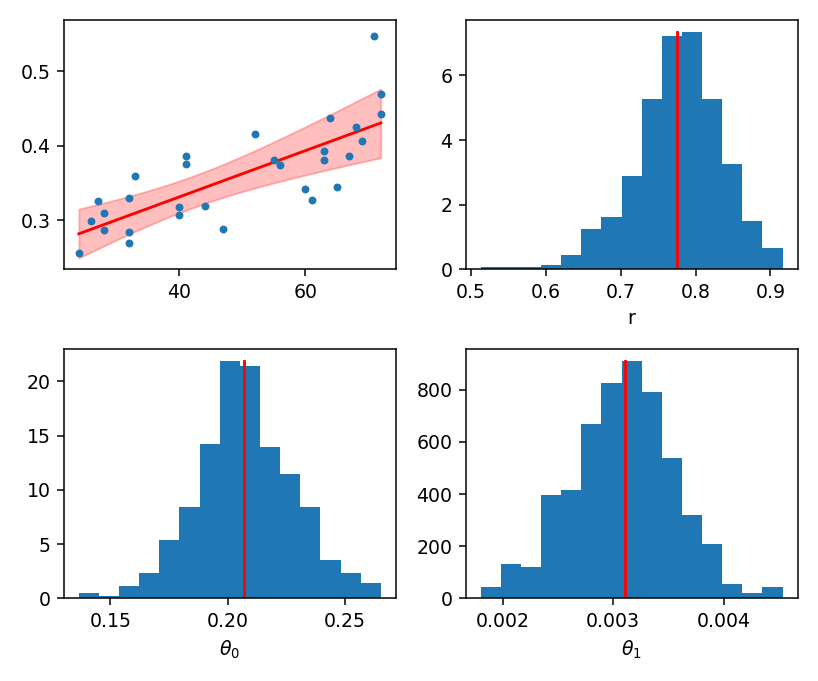

interactive(children=(SelectionSlider(description='T', index=2, options=(10, 20, 50, 100, 200, 500), value=50)…

In [58]:
import pandas as pd
!wget -nc -c https://forge.scilab.org/index.php/p/rdataset/source/file/master/csv/Ecdat/Icecream.csv
df = pd.read_csv('Icecream.csv', header=0, index_col=0)
df.columns = ['consumo', 'ingreso', 'precio', 'temperatura']
display(df.head())
!rm Icecream.csv


import ipywidgets as widgets

fig, ax = plt.subplots(2, 2, figsize=(6, 5), tight_layout=True)
x, y = df["temperatura"].values, df["consumo"].values
x_plot = np.linspace(np.amin(x), np. amax(x), num=100)
res_all = scipy.stats.linregress(x, y)
M = len(x)

def update_plot(T):
    [ax_.cla() for ax_ in ax.ravel()]
    ax[0, 0].scatter(x, y, zorder=100, s=10)
    np.random.seed(0)
    param = np.zeros(shape=(T, 3))
    lines = []
    for t in range(T):
        bootstrap_idx = np.random.choice(np.arange(len(x)), size=len(x), replace=True)
        res = scipy.stats.linregress(x[bootstrap_idx], y[bootstrap_idx])
        lines.append(x_plot*res.slope + res.intercept)
        #ax[0, 0].plot(x_plot, x_plot*res.slope + res.intercept, alpha=0.05, c='k')
        param[t, :] = [res.intercept, res.slope, res.rvalue]
    ax[0, 0].plot(x_plot, x_plot*res_all.slope + res_all.intercept, alpha=1, c='r')
    lines = np.stack(lines)
    ax[0, 0].fill_between(x_plot, np.mean(lines, axis=0)-3*np.std(lines, axis=0), 
                          np.mean(lines, axis=0)+3*np.std(lines, axis=0), color='r', alpha=0.25)
    hist_val, hist_lim, _ = ax[0, 1].hist(param[:, 2], bins=15, density=True)
    ax[0, 1].plot([res_all.rvalue]*2, [0, np.max(hist_val)], c='r')
    ax[0, 1].set_xlabel('r')
    display("Intervalo de confianza al 95% de r {}".format(np.percentile(param[:, 2], [2.5, 97.5])))
    hist_val, hist_lim, _ = ax[1, 0].hist(param[:, 0], bins=15, density=True)
    ax[1, 0].plot([res_all.intercept]*2, [0, np.max(hist_val)], c='r')
    ax[1, 0].set_xlabel(r'$\theta_0$')
    display("Intervalo de confianza al 95% de theta_0 {}".format(np.percentile(param[:, 0], [2.5, 97.5])))
    hist_val, hist_lim, _ = ax[1, 1].hist(param[:, 1], bins=15, density=True)
    ax[1, 1].plot([res_all.slope]*2, [0, np.max(hist_val)], c='r')
    ax[1, 1].set_xlabel(r'$\theta_1$')
    display("Intervalo de confianza al 95% de theta_1 {}".format(np.percentile(param[:, 1], [2.5, 97.5])))

widgets.interact(update_plot, T=widgets.SelectionSlider(options=[10, 20, 50, 100, 200, 500], value=50));